## Imports

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

## Data import

In [2]:
cars_file = "https://gist.githubusercontent.com/noamross/e5d3e859aa0c794be10b/raw/b999fb4425b54c63cab088c0ce2c0d6ce961a563/cars.csv"
cars = pd.read_csv(cars_file)
cars.head(10)

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
5,Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
6,Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
7,Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
8,Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
9,Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


#### Visualise the model

<AxesSubplot:xlabel='wt', ylabel='mpg'>

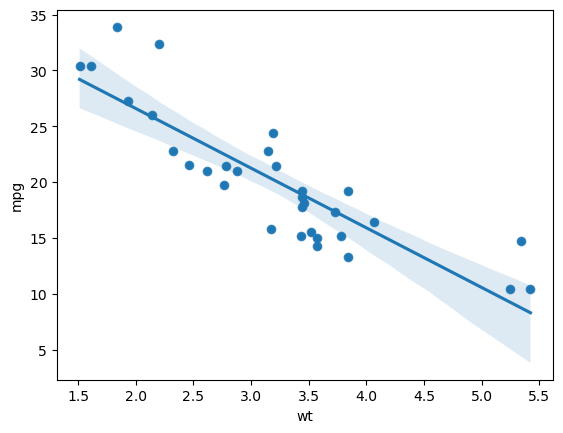

In [3]:
sns.scatterplot(x = "wt", y = "mpg", data = cars)
sns.regplot(x = "wt", y = "mpg", data = cars)

#### Convert data to tensors

In [4]:
x_list = cars.wt.values
x_np = np.array(x_list, dtype = np.float32).reshape(-1, 1)
y_list = cars.mpg.values
y_np = np.array(y_list, dtype = np.float32).reshape(-1, 1)
x = torch.from_numpy(x_np)
y_true = torch.from_numpy(y_np)

## Dataset and Dataloader

In [5]:
class LinearRegressionDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
train_loader = DataLoader(dataset = LinearRegressionDataset(x_np, y_np), batch_size = 2)

## Model Class

In [6]:
class LinearRegressionTorch(nn.Module):
    def __init__(self, input_size, output_size, learning_rate):
        super(LinearRegressionTorch, self).__init__() # Inherited from parent
        self.linear = nn.Linear(input_size, output_size)
        self.loss_fun = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.parameters(), lr = learning_rate)
        
    def forward(self, x):
        return self.linear(x) # Built-in method inherited from nn.Module

input_dim = 1
output_dim = 1
LR = 0.02
model = LinearRegressionTorch(input_size = input_dim, output_size = output_dim, learning_rate = LR)

## Perform Taining

In [7]:
losses, slope, bias = [], [], []
Num_Epoch = 1000
for epoch in range(Num_Epoch):
    for j, (x, y) in enumerate(train_loader):
        # Set gradients to zero (You should do that at the begining of the each epoch)
        model.optimizer.zero_grad()

        # Forward prop
        y_pred = model(x) # We don't actually have to call forward method. Take a look to __call__ method of the nn.module.

        # Calculate loss
        loss = model.loss_fun(y_pred, y)
        losses.append(float(loss.item()))
        
        # Back prop
        loss.backward() # gradients calculated and optimizer knows them

        # Update parameters
        model.optimizer.step()

    # Get parameters
    for name, param in model.named_parameters():
        if param.requires_grad:
            if name == "linear.weight":
                slope.append(param.data.numpy()[0][0])
            if name == "linear.bias":
                bias.append(param.data.numpy()[0])
    
    #print loss
    if(epoch % 100 == 0):
        print(f"Epoch {epoch}, Loss: {loss.data}")

Epoch 0, Loss: 34.71247482299805
Epoch 100, Loss: 1.5656794309616089
Epoch 200, Loss: 1.4115055799484253
Epoch 300, Loss: 1.4094297885894775
Epoch 400, Loss: 1.409427285194397
Epoch 500, Loss: 1.409427285194397
Epoch 600, Loss: 1.409427285194397
Epoch 700, Loss: 1.409427285194397
Epoch 800, Loss: 1.409427285194397
Epoch 900, Loss: 1.409427285194397


## Visualise Model Training

#### visualise the loss

<AxesSubplot:>

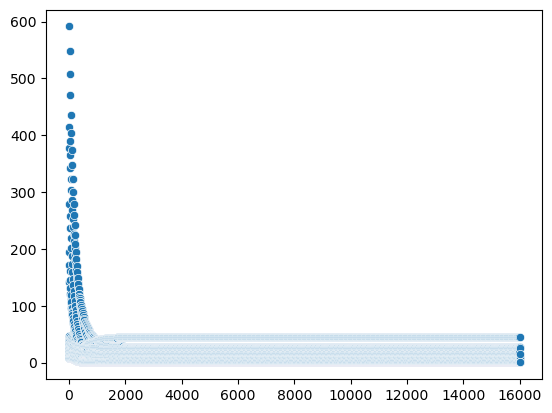

In [8]:
sns.scatterplot(x = range(len(losses)), y = losses) 

#### visualise the bias development

36.693535

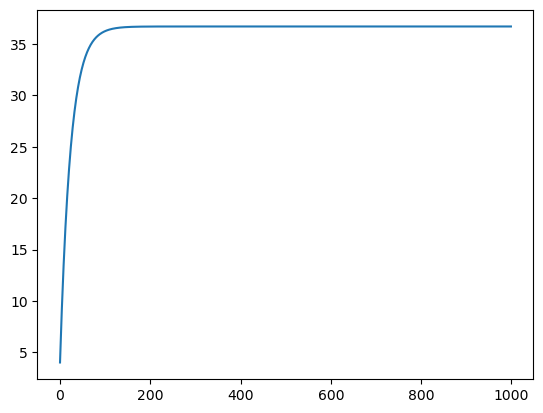

In [9]:
sns.lineplot(x = range(Num_Epoch), y = bias)
max(bias)

#### visualise the slope development

-5.722539

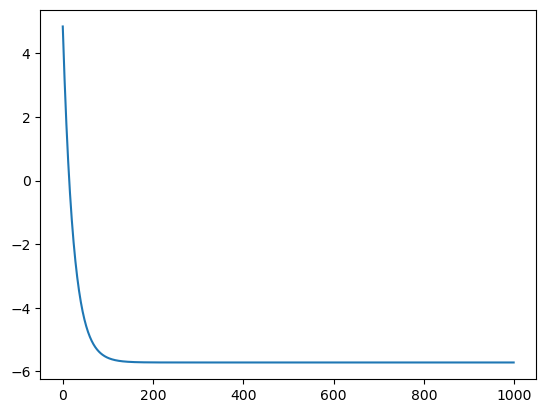

In [10]:
sns.lineplot(x = range(Num_Epoch), y = slope)
min(slope)

## Check The Results 

(32,) (32,)


<AxesSubplot:>

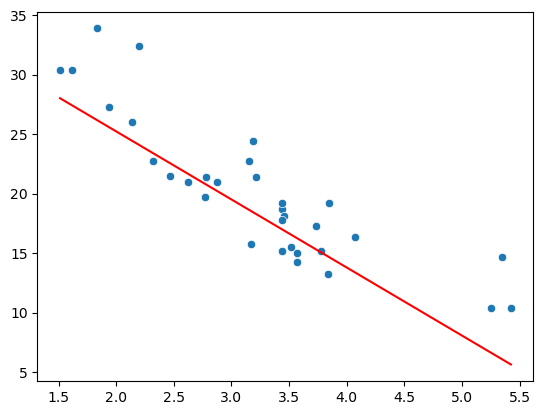

In [11]:
model.eval()
y_pred_list = []
with torch.no_grad():
    for batch_x, _ in train_loader:
        batch_y_pred = model(batch_x)
        y_pred_list.append(batch_y_pred)

y_pred_tensor = torch.cat(y_pred_list, dim=0)
y_pred = y_pred_tensor[:, 0].numpy()

y = y_true[:, 0].numpy()

print(np.array(x_list).shape, np.array(y_pred).shape)
sns.scatterplot(x = x_list, y = y)
sns.lineplot(x = x_list, y = y_pred, color = "red")